In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from preprocessing.opp_preprocess import *
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

In [3]:
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import sys
# import yaml

# sys.path.append("../")

# from preprocessing.opp_preprocess import *
# from model.hierarchical_self_attention_model import HSA_model_session_guided_window

# def session_length_variation():
#     activity_list = ['Other', 'Open Door 1', 'Open Door 2', 'Close Door 1',
#                     'Close Door 2', 'Open Fridge', 'Close Fridge', 
#                     'Open Dishwasher', 'Close Dishwasher', 'Open Drawer 1', 
#                     'Close Drawer 1', 'Open Drawer 2', 'Close Drawer 2', 
#                     'Open Drawer 3', 'Close Drawer 3', 'Clean Table', 
#                     'Drink from Cup', 'Toggle Switch']
    
#     DATA_PATH = '/home/hariub/data/HAR/processed/clean_opp_nodrill.csv'
#     df = pd.read_csv(DATA_PATH)
    
#     FEATURES = [str(i) for i in range(77)]
#     LOCO_LABEL_COL = 77
#     MID_LABEL_COL = 78
#     HI_LABEL_COL = 79
#     SUBJECT_ID = 80
#     RUN_ID = 81
    
#     df[FEATURES] = df[FEATURES].interpolate(method='linear', axis=0)
#     df = df.fillna(0)
#     scaler = StandardScaler()
#     df[FEATURES] = scaler.fit_transform(df[FEATURES])

#     BENCHMARK_TEST = ((df[str(SUBJECT_ID)] == 2) | (df[str(SUBJECT_ID)] == 3)) & (
#                 (df[str(RUN_ID)] == 4) | (df[str(RUN_ID)] == 5))

#     train_df = df[~ BENCHMARK_TEST]
#     test_df = df[BENCHMARK_TEST]
    
#     session_len_list = [20, 30, 40, 50, 60, 90, 120 ]
#     for session_len in session_len_list:
#         SLIDING_WINDOW_LENGTH = session_len
#         SLIDING_WINDOW_STEP = SLIDING_WINDOW_LENGTH // 2
#         N_WINDOW, N_TIMESTEP = 10, SLIDING_WINDOW_LENGTH //10

#         X_train, y_train, m_labels_tr, loco_labels_tr = create_windowed_dataset_opp(train_df, FEATURES, str(
#             MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
#         X_test, y_test, m_labels_ts, loco_labels_ts = create_windowed_dataset_opp(test_df, FEATURES, str(
#             MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

#         X_train = X_train.reshape(
#             (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
#         X_test = X_test.reshape(
#             (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

#         y_train = tf.keras.utils.to_categorical(y_train)
#         y_test = tf.keras.utils.to_categorical(y_test)
        
#         y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=N_WINDOW, axis=1)
#         # y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=N_WINDOW, axis=1)
#         y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=N_WINDOW, axis=1)
        
#         hparam_file = open('../configs/hyperparameters.yaml', mode='r')
#         hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
#         DATASET_NAME = 'opp'
#         hparams_all = hyperparameters['HSA_model']
#         hparams = hparams_all[DATASET_NAME]

#         hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
#         hparams['n_outputs_window']=  y_train.shape[1]
        
#         tf.keras.backend.clear_session()
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#           try:
#             # Currently, memory growth needs to be the same across GPUs
#             for gpu in gpus:
#               tf.config.experimental.set_memory_growth(gpu, True)
#             logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#           except RuntimeError as e:
#             # Memory growth must be set before GPUs have been initialized
#             print(e)

#         device_list = ['/gpu:'+str(i) for i in range(5, 8)]
#         strategy = tf.distribute.MirroredStrategy(devices=device_list)
#         print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
#         with strategy.scope():
#             model = HSA_model_session_guided_window(**hparams).get_compiled_model()
            
#         checkpoint_filepath = f"opp_checkpoints/session_var/cp-{session_len}" + "-{epoch:04d}.ckpt"
#         model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#                                                                        save_weights_only=True)
        
#         model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 128, epochs=1, validation_split=0.1, use_multiprocessing=True, callbacks=[model_checkpoint_callback], verbose=2)
        
#         model_from_ckpt = HSA_model_session_guided_window(**hparams).get_compiled_model()
#         model_from_ckpt.load_weights("opp_checkpoints/cp-0001.ckpt")
#         pred_mid, pred_sess =model_from_ckpt.predict(X_test, batch_size= 64)
        
#         if not os.path.exists('result'):
#             os.mkdir('result')
            
#         out_res_s = open(os.path.join('result',
#                                     str('session_' + str(session_len).zfill(3) + '_session' + '.txt')), 'w')
        
        
# #         print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), target_names=activity_list))
#         print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), target_names=activity_list), file=out_res_s)
        
#         confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), normalize='pred')
#         df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
#         plt.figure(figsize = (20,15))
#         sns.heatmap(df_cm, annot=True, fmt='0.3f', cmap="YlGnBu")
        
#         if not os.path.exists('figures'):
#             os.mkdir('figures')
#         out_fig = 'session_' + str(session_len).zfill(3) + '.png'
#         plt.savefig(os.path.join('figures', out_fig))
        
#         out_res_w = open(os.path.join('result',
#                                     str('session_' + str(session_len).zfill(3) + '_window' + '.txt')), 'w')
# #         print(classification_report(np.argmax(y_test_mid.reshape(-1, 18), axis=1), np.argmax(pred_mid.reshape(-1, 18), axis=1), target_names=activity_list))
#         print(classification_report(np.argmax(y_test_mid.reshape(-1, 18), axis=1), np.argmax(pred_mid.reshape(-1, 18), axis=1), target_names=activity_list), file=out_res_w)

In [4]:
# session_length_variation()

In [5]:
DATA_PATH = '/home/hariub/data/HAR/processed/clean_opp_nodrill.csv'
df = pd.read_csv(DATA_PATH)

metadata_file = open('../configs/metadata.yaml', mode='r')
metadata = yaml.load(metadata_file, Loader=yaml.FullLoader)['opp_preprocess']
FEATURES = [str(i) for i in range(77)]
LOCO_LABEL_COL = 77
MID_LABEL_COL = 78
HI_LABEL_COL = 79
SUBJECT_ID = 80
RUN_ID = 81

# df = df[df[str(HI_LABEL_COL)] != 0]
df[FEATURES] = df[FEATURES].interpolate(method='linear', axis=0)
df = df.fillna(0)

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

BENCHMARK_TEST = ((df[str(SUBJECT_ID)] == 2) | (df[str(SUBJECT_ID)] == 3)) & (
            (df[str(RUN_ID)] == 4) | (df[str(RUN_ID)] == 5))

train_df = df[~ BENCHMARK_TEST]
test_df = df[BENCHMARK_TEST]

SLIDING_WINDOW_LENGTH = 30
SLIDING_WINDOW_STEP = 15
N_WINDOW, N_TIMESTEP = 10, 3

X_train, y_train, m_labels_tr, loco_labels_tr = create_windowed_dataset_opp(train_df, FEATURES, str(
    MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test, m_labels_ts, loco_labels_ts = create_windowed_dataset_opp(test_df, FEATURES, str(
    MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
np.asarray(m_labels_tr).shape

(31915, 30)

In [7]:
y_train.shape

(31915, 18)

In [8]:
print(X_train.shape)
print(y_train.shape)

(31915, 10, 3, 77)
(31915, 18)


In [9]:
X_test.shape

(7298, 10, 3, 77)

In [10]:
# m_labels_tr = np.asarray(m_labels_tr).reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP))
# m_labels_ts = np.asarray(m_labels_ts).reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP))

In [11]:
# y_train_mid = np.zeros((X_train.shape[0], N_WINDOW))
# for i in range(len(y_train_mid)):
#     for j in range(N_WINDOW):
#         y_train_mid[i,j] = np.bincount(m_labels_tr[i, j]).argmax()
        
# y_test_mid = np.zeros((X_test.shape[0], N_WINDOW))
# for i in range(len(y_test_mid)):
#     for j in range(N_WINDOW):
#         y_test_mid[i,j] = np.bincount(m_labels_ts[i, j]).argmax()

In [12]:
# y_train_mid = tf.keras.utils.to_categorical(y_train_mid)
# y_test_mid = tf.keras.utils.to_categorical(y_test_mid)

In [13]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=N_WINDOW, axis=1)
# y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=N_WINDOW, axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=N_WINDOW, axis=1)

In [14]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
DATASET_NAME = 'opp'
hparams_all = hyperparameters['HSA_model']
hparams = hparams_all[DATASET_NAME]

hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [15]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
device_list = ['/gpu:'+str(i) for i in range(5, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 3, 77)]  0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 1249472     input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_7 (Modal (None, None, 64)     170048      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  82880       modality_encoder_block_7[0][0]   
____________________________________________________________________________________________

In [17]:
checkpoint_filepath = "opp_checkpoints/cp-{epoch:04d}.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True)                            

In [18]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 128, epochs=60, validation_split=0.1, use_multiprocessing=True, callbacks=[model_checkpoint_callback])

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 292 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devi

In [67]:
# model.evaluate(X_test, [y_test_mid, y_test])

In [20]:
# pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [30]:
model_from_ckpt = HSA_model_session_guided_window(**hparams).get_compiled_model()
model_from_ckpt.load_weights("opp_checkpoints/cp-0055.ckpt")

In [31]:
pred_mid, pred_sess =model_from_ckpt.predict(X_test, batch_size= 64)

In [32]:
activity_list = ['Other', 'Open Door 1', 'Open Door 2', 'Close Door 1',
                    'Close Door 2', 'Open Fridge', 'Close Fridge', 
                    'Open Dishwasher', 'Close Dishwasher', 'Open Drawer 1', 
                    'Close Drawer 1', 'Open Drawer 2', 'Close Drawer 2', 
                    'Open Drawer 3', 'Close Drawer 3', 'Clean Table', 
                    'Drink from Cup', 'Toggle Switch']

In [33]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), target_names=activity_list))

                  precision    recall  f1-score   support

           Other       0.96      0.97      0.97      6270
     Open Door 1       0.76      0.74      0.75        38
     Open Door 2       0.92      0.89      0.91        66
    Close Door 1       0.74      0.83      0.78        41
    Close Door 2       0.92      0.87      0.90        54
     Open Fridge       0.77      0.70      0.74       141
    Close Fridge       0.94      0.77      0.85        88
 Open Dishwasher       0.54      0.84      0.66        57
Close Dishwasher       0.41      0.79      0.54        42
   Open Drawer 1       1.00      0.20      0.33        20
  Close Drawer 1       0.56      0.38      0.45        24
   Open Drawer 2       1.00      0.29      0.44        21
  Close Drawer 2       0.60      0.50      0.55        12
   Open Drawer 3       0.77      0.83      0.80        36
  Close Drawer 3       0.64      0.83      0.72        30
     Clean Table       0.82      0.51      0.63        70
  Drink from 

In [34]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), target_names=activity_list))

                  precision    recall  f1-score   support

           Other       0.96      0.97      0.97      6270
     Open Door 1       0.76      0.74      0.75        38
     Open Door 2       0.92      0.89      0.91        66
    Close Door 1       0.74      0.83      0.78        41
    Close Door 2       0.92      0.87      0.90        54
     Open Fridge       0.77      0.70      0.74       141
    Close Fridge       0.94      0.77      0.85        88
 Open Dishwasher       0.54      0.84      0.66        57
Close Dishwasher       0.41      0.79      0.54        42
   Open Drawer 1       1.00      0.20      0.33        20
  Close Drawer 1       0.56      0.38      0.45        24
   Open Drawer 2       1.00      0.29      0.44        21
  Close Drawer 2       0.60      0.50      0.55        12
   Open Drawer 3       0.77      0.83      0.80        36
  Close Drawer 3       0.64      0.83      0.72        30
     Clean Table       0.82      0.51      0.63        70
  Drink from 

<AxesSubplot:>

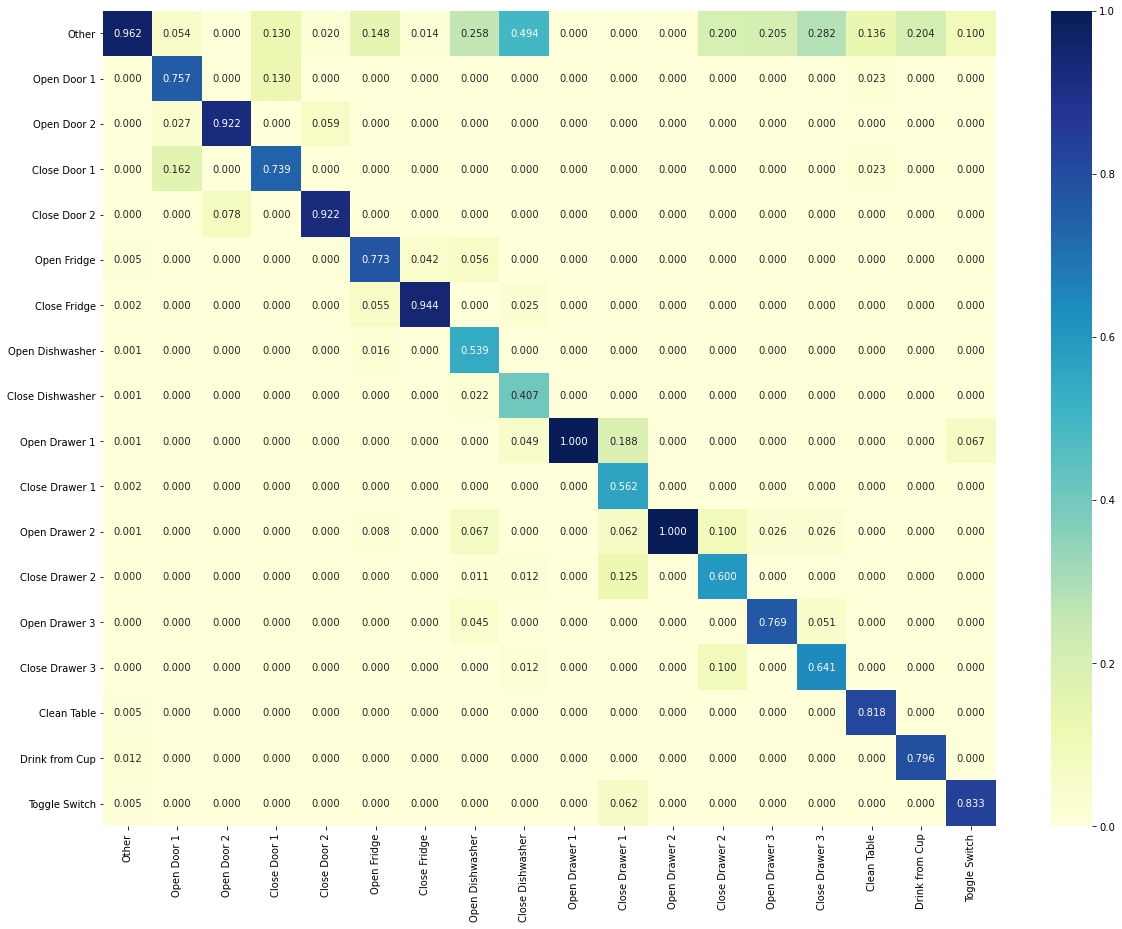

In [35]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), normalize='pred')

df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (20,15))
sns.heatmap(df_cm, annot=True, fmt='0.3f', cmap="YlGnBu")

In [36]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 18), axis=1), np.argmax(pred_mid.reshape(-1, 18), axis=1), target_names=activity_list))

                  precision    recall  f1-score   support

           Other       0.96      0.98      0.97     62700
     Open Door 1       0.77      0.74      0.76       380
     Open Door 2       0.92      0.90      0.91       660
    Close Door 1       0.74      0.81      0.77       410
    Close Door 2       0.94      0.86      0.90       540
     Open Fridge       0.78      0.70      0.74      1410
    Close Fridge       0.95      0.75      0.84       880
 Open Dishwasher       0.55      0.84      0.66       570
Close Dishwasher       0.41      0.77      0.54       420
   Open Drawer 1       0.77      0.18      0.30       200
  Close Drawer 1       0.59      0.39      0.47       240
   Open Drawer 2       0.92      0.27      0.42       210
  Close Drawer 2       0.61      0.47      0.54       120
   Open Drawer 3       0.77      0.82      0.79       360
  Close Drawer 3       0.66      0.82      0.73       300
     Clean Table       0.84      0.51      0.64       700
  Drink from 